In [1]:
# Problem Statement : To predict how likely individuals are to receive their H1N1 vaccines

In [3]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# Load the dataset
df = pd.read_csv("public_health_response.csv")

# Replace empty strings with NaN
df.replace("", np.nan, inplace=True)

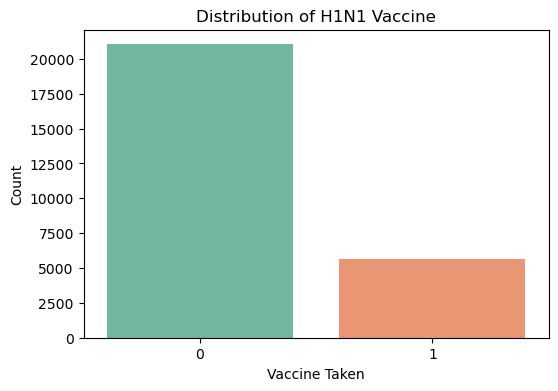

In [5]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='h1n1_vaccine', data=df, palette='Set2')
plt.title('Distribution of H1N1 Vaccine')
plt.xlabel('Vaccine Taken')
plt.ylabel('Count')
plt.show()

In [6]:
# Display the first few rows of the dataset
print("First five rows of the dataset:")
print(df.head())

# Check the dimensions of the dataset
print("\nDimensions of the original dataset:")
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

# Check for missing values
print("\nTotal missing values:")
print(df.isnull().sum())

# Statistics of numerical features
print("\nSummary of numerical features:")
print(df.describe())

First five rows of the dataset:
   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0            

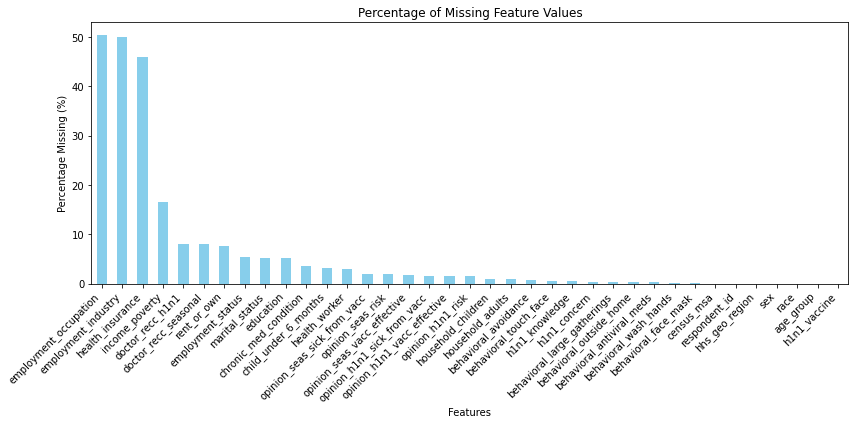

In [29]:
# Calculate the percentage of missing feature values
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Sort the features based on their missing percentage
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

# Plot the missing percentage
plt.figure(figsize=(12, 6))
missing_percentage_sorted.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Feature Values')
plt.xlabel('Features')
plt.ylabel('Percentage Missing (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

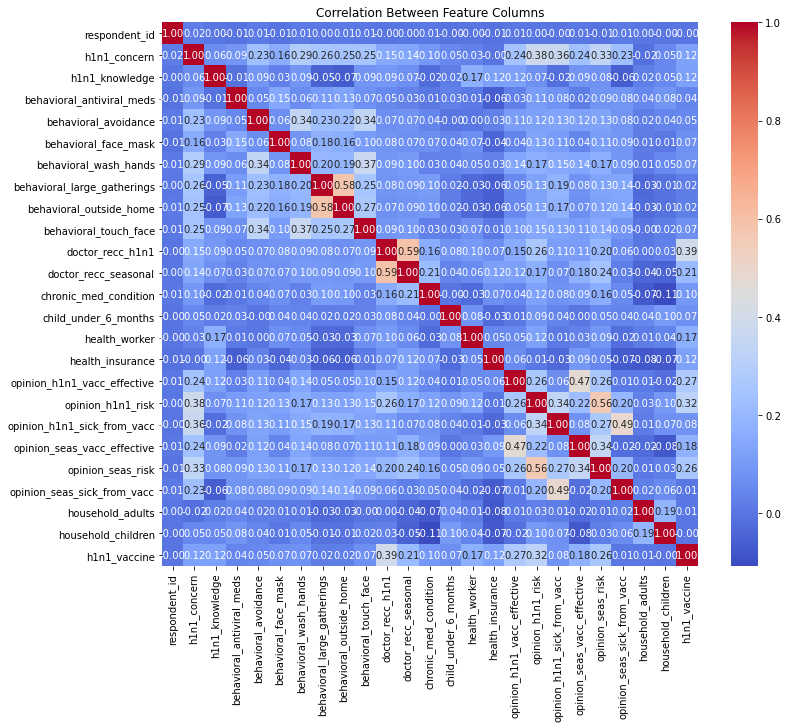

In [30]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Feature Columns')
plt.show()

In [31]:
# Calculate the number of missing values per row
missing_values_per_row = df.isnull().sum(axis=1)

# Add a new column to the DataFrame to store the count of missing values per row
df['missing_values_count'] = missing_values_per_row

# Sort the DataFrame by the count of missing values in descending order
df = df.sort_values(by='missing_values_count', ascending=False)

# Number of rows before cleansing
rows_before = df.shape[0]
print("Number of rows before cleansing:",rows_before)

# Number of columns in the dataframe
columns_before = df.shape[1]

# Print the number of columns in the cleaned dataframe
print("Number of columns before cleansing:", columns_before)

# Filter out rows with missing values less than or equal to 5
missing_values_per_row = missing_values_per_row.reindex(df.index)
df = df[missing_values_per_row <= 5]

# Get the number of rows with missing values greater than 5
total_rows_with_many_missing = (missing_values_per_row > 5).sum()

# Print the number of rows with missing values greater than 5
print("Number of rows with missing values greater than 5:", total_rows_with_many_missing)

# Number of rows after cleansing
rows_after = df.shape[0]
print("Number of rows after cleansing:",rows_after)

Number of rows before cleansing: 26707
Number of columns before cleansing: 38
Number of rows with missing values greater than 5: 1609
Number of rows after cleansing: 25098


In [32]:
# Impute missing values with mode
def mode_impute(x):
    ux = x[~np.isnan(x)].unique()
    return ux[np.argmax(np.array([sum(x == val) for val in ux]))]

df['doctor_recc_h1n1'] = df['doctor_recc_h1n1'].fillna(mode_impute(df['doctor_recc_h1n1']))
df['chronic_med_condition'] = df['chronic_med_condition'].fillna(mode_impute(df['chronic_med_condition']))

vars_behavioral = ["behavioral_avoidance", "behavioral_touch_face"]
for var in vars_behavioral:
    df[var] = df[var].fillna(mode_impute(df[var]))

df['household_adults'] = df['household_adults'].fillna(df['household_adults'].median())
df['household_children'] = df['household_children'].fillna(df['household_children'].median())

# Drop unnecessary columns
#df.drop(columns=['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'], inplace=True)

# Impute missing values with mode for categorical variables
categorical_vars = ["h1n1_concern", "h1n1_knowledge", "health_worker",
                    "opinion_h1n1_vacc_effective", "opinion_h1n1_risk", "opinion_h1n1_sick_from_vacc", "opinion_seas_vacc_effective",
                    "opinion_seas_risk", "opinion_seas_sick_from_vacc"]

for var in categorical_vars:
    df[var] = df[var].fillna(df[var].mode()[0])

# Convert 'sex' column to numeric
df['sex'] = df['sex'].map({'Male': 1, 'Female': 2})

# Map age_group to numeric
age_group_mapping = {"18 - 34 Years": 1, "35 - 44 Years": 2, "45 - 54 Years": 3, "55 - 64 Years": 4, "65+ Years": 5}
df['age_group'] = df['age_group'].map(age_group_mapping)
df['age_group'].fillna(df['age_group'].mode()[0], inplace=True)

# Handle 'income_poverty' column
df['income_poverty'].replace('', np.nan, inplace=True)
df['income_poverty'] = df['income_poverty'].map({"Below Poverty": 1, "<= $75,000, Above Poverty": 2, "> $75,000": 3})
df['income_poverty'].fillna(df['income_poverty'].mode()[0], inplace=True)

# Convert 'education' column to numeric
education_mapping = {"< 12 Years": 1, "12 Years": 2, "College Graduate": 3, "Some College": 4}
df['education'] = df['education'].map(education_mapping)
df['education'].fillna(df['education'].mode()[0], inplace=True)

# Map 'race' column to numeric
race_mapping = {"Black": 1, "Hispanic": 2, "Other or Multiple": 3, "White": 4}
df['race'] = df['race'].map(race_mapping)
df['race'].fillna(df['race'].mode()[0], inplace=True)

# Map 'employment_status' column to numeric
employment_status_mapping = {"Not in Labor Force": 1, "Employed": 2, "Unemployed": 3}
df['employment_status'] = df['employment_status'].map(employment_status_mapping)
df['employment_status'].fillna(df['employment_status'].mode()[0], inplace=True)

# Convert h1n1_vaccine to categorical
df['h1n1_vaccine'] = pd.Categorical(df['h1n1_vaccine'], categories=[0, 1], ordered=True)

# Drop columns
df.drop(columns=['hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation','health_insurance','behavioral_antiviral_meds', 'behavioral_face_mask', 'child_under_6_months',
                'behavioral_wash_hands', 'rent_or_own', 'doctor_recc_seasonal', 'marital_status', 'behavioral_outside_home', 'behavioral_large_gatherings', 'missing_values_count'], inplace=True)


# Number of columns in the dataframe
columns_after = df.shape[1]

# Print the number of columns in the cleaned dataframe
print("Number of columns after cleansing:", columns_after)

Number of columns after cleansing: 23


                             importance
doctor_recc_h1n1               0.157965
opinion_h1n1_risk              0.065214
opinion_h1n1_vacc_effective    0.064643
age_group                      0.061125
education                      0.056611
opinion_seas_risk              0.052866
h1n1_concern                   0.052554
opinion_h1n1_sick_from_vacc    0.050476
opinion_seas_sick_from_vacc    0.050333
household_adults               0.047448
opinion_seas_vacc_effective    0.042024
h1n1_knowledge                 0.037702
income_poverty                 0.037545
household_children             0.036426
employment_status              0.032429
race                           0.030134
chronic_med_condition          0.025864
sex                            0.025858
behavioral_touch_face          0.024894
health_worker                  0.024277
behavioral_avoidance           0.023613


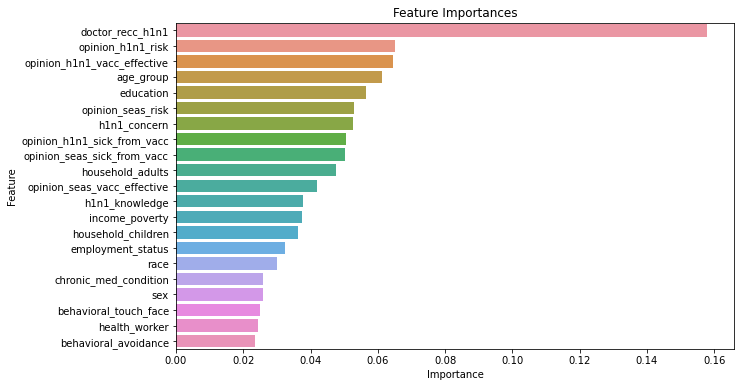

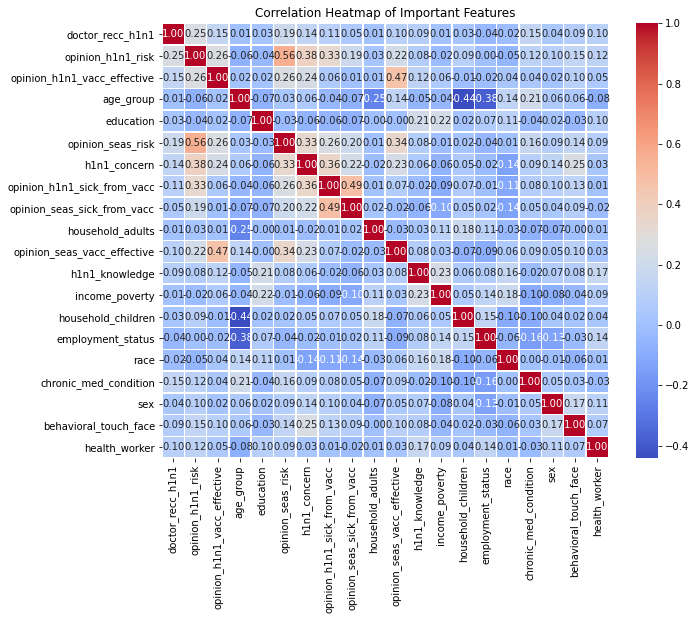

In [33]:
# Training the model

# Split the dataset into features and target variable

X = df.drop(columns=['h1n1_vaccine', 'respondent_id'])
y = df['h1n1_vaccine']

# feature extraction


# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Print feature importances
print(feature_importances)

# Bar Plot for Important Features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

 # Select top 20 important features
important_features = feature_importances.index[:20]

# Correlation Heatmap for Important Features
corr = df[important_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Important Features')
plt.show()

# Reassign X with only the top 20 features
X = df[important_features]


In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


# Normalize the data (Min-Max Scaling)
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


In [35]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Accuracy of kNN model: 0.8277556440903054


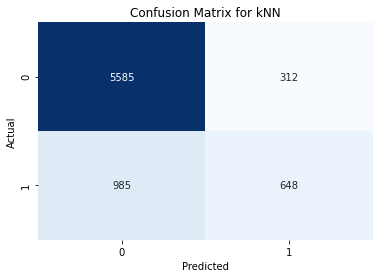


Classification Report for knn:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      5897
           1       0.68      0.40      0.50      1633

    accuracy                           0.83      7530
   macro avg       0.76      0.67      0.70      7530
weighted avg       0.81      0.83      0.81      7530



In [36]:
# Train the kNN model
k = 163
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_normalized, y_train)

# Predict on test set
y_pred = knn_model.predict(X_test_normalized)

# Evaluate the model's performance
knn_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of kNN model:", knn_accuracy)

# Plot confusion matrix for kNN model
plot_confusion_matrix(y_test, y_pred, 'kNN')

# plot classification report
print("\nClassification Report for knn:")
print(classification_report(y_test, y_pred))


Accuracy of Logistic Regression model: 0.8353253652058433


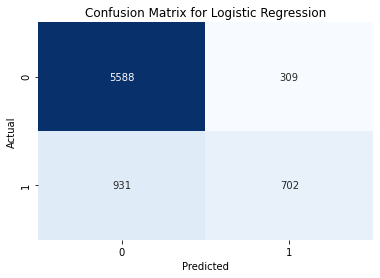


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5897
           1       0.69      0.43      0.53      1633

    accuracy                           0.84      7530
   macro avg       0.78      0.69      0.72      7530
weighted avg       0.82      0.84      0.82      7530



In [37]:
#Logistic regression

# Train the Logistic Regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = log_reg_model.predict(X_test_normalized)

# Evaluate the model's performance
accuracy_log_reg = accuracy_score(y_test, y_pred)
print("Accuracy of Logistic Regression model:", accuracy_log_reg)

# Plot confusion matrix for Logistic Regression model
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression')

# plot classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))


Accuracy of Naive Bayes classifier: 0.7899070385126162


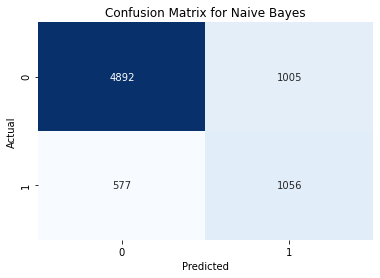


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5897
           1       0.51      0.65      0.57      1633

    accuracy                           0.79      7530
   macro avg       0.70      0.74      0.72      7530
weighted avg       0.81      0.79      0.80      7530



In [38]:
# Naive Bayes

# Initialize and train the Naive Bayes classifier
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Predict on test set
y_pred = naive_bayes.predict(X_test)

# Evaluate the model's performance
accuracy_naive_bayes = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes classifier:", accuracy_naive_bayes)

# Plot confusion matrix for Naive Bayes model
plot_confusion_matrix(y_test, y_pred, 'Naive Bayes')

# plot classification report
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test, y_pred))


Accuracy of SVM model: 0.8244355909694555


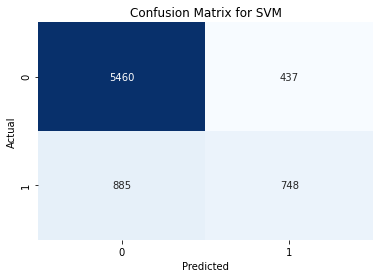


Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      5897
           1       0.63      0.46      0.53      1633

    accuracy                           0.82      7530
   macro avg       0.75      0.69      0.71      7530
weighted avg       0.81      0.82      0.81      7530



In [39]:
# SVM

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=123)  # You can try different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_normalized, y_train)

# Predict on test set
y_pred = svm_model.predict(X_test_normalized)

# Evaluate the model's performance
accuracy_svm = accuracy_score(y_test, y_pred)
print("Accuracy of SVM model:", accuracy_svm)

# Plot confusion matrix for SVM model
plot_confusion_matrix(y_test, y_pred, 'SVM')

# plot classification report
print("\nClassification Report for SVM:")
print(classification_report(y_test, y_pred))

Accuracy of Decision Tree model: 0.752589641434263


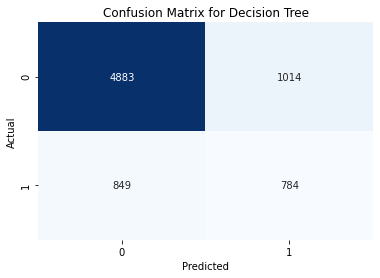


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      5897
           1       0.44      0.48      0.46      1633

    accuracy                           0.75      7530
   macro avg       0.64      0.65      0.65      7530
weighted avg       0.76      0.75      0.76      7530

Accuracy of Decision Tree model with hyper parameter: 0.8166002656042497


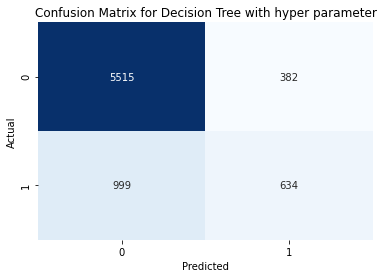


Classification Report for Decision Tree with hyper parameter:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5897
           1       0.62      0.39      0.48      1633

    accuracy                           0.82      7530
   macro avg       0.74      0.66      0.68      7530
weighted avg       0.80      0.82      0.80      7530



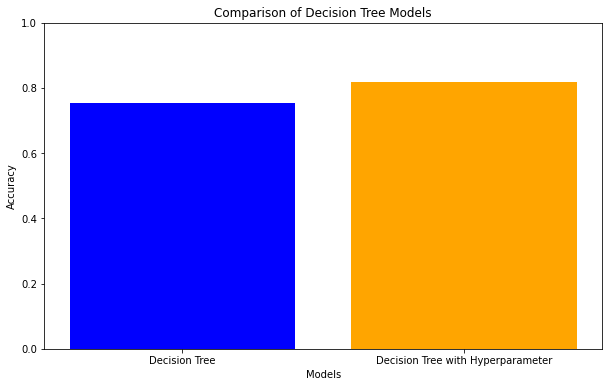

In [40]:
# Decision tree

# Train the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=123)
decision_tree_model.fit(X_train, y_train)

# Predict on test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model's performance
accuracy_decision_tree = accuracy_score(y_test, y_pred)
print("Accuracy of Decision Tree model:", accuracy_decision_tree)

# Plot confusion matrix for Decision Tree model
plot_confusion_matrix(y_test, y_pred, 'Decision Tree')

# plot classification report
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred))

from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the Decision Tree model with the best parameters
decision_tree_model = DecisionTreeClassifier(**best_params, random_state=123)
decision_tree_model.fit(X_train, y_train)

# Predict on test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model's performance
accuracy_decision_tree_hyper_param = accuracy_score(y_test, y_pred)
print("Accuracy of Decision Tree model with hyper parameter:", accuracy_decision_tree_hyper_param)

# Plot confusion matrix for Decision Tree model
plot_confusion_matrix(y_test, y_pred, 'Decision Tree with hyper parameter')

# Plot classification report
print("\nClassification Report for Decision Tree with hyper parameter:")
print(classification_report(y_test, y_pred))


# Define the accuracies
accuracies = [accuracy_decision_tree, accuracy_decision_tree_hyper_param]

# Define the labels
models = ['Decision Tree', 'Decision Tree with Hyperparameter']

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Decision Tree Models')
plt.ylim(0, 1) 
plt.show()

Accuracy of Random Forest model: 0.8317397078353254


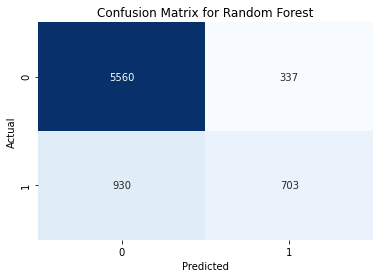


Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      5897
           1       0.68      0.43      0.53      1633

    accuracy                           0.83      7530
   macro avg       0.77      0.69      0.71      7530
weighted avg       0.82      0.83      0.82      7530

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy for Random forest with Hyperparameter: 0.8357237715803453


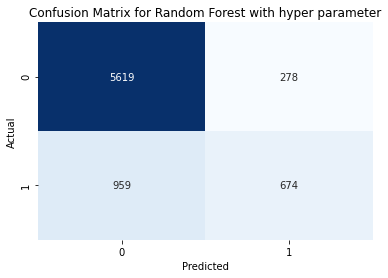


Classification Report for Random Forest with hyper parameter:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      5897
           1       0.71      0.41      0.52      1633

    accuracy                           0.84      7530
   macro avg       0.78      0.68      0.71      7530
weighted avg       0.82      0.84      0.82      7530



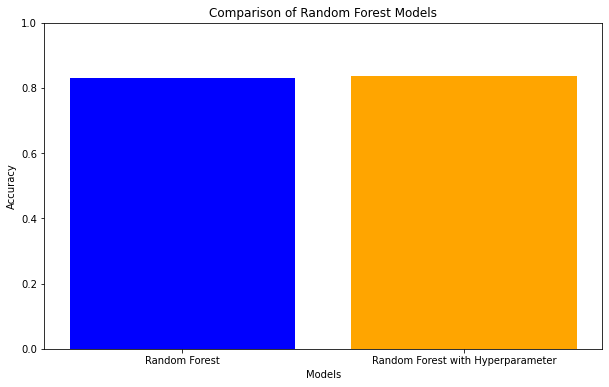

In [41]:
#random forest

# Train the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=123)
random_forest_model.fit(X_train, y_train)

# Predict on test set using Random Forest
y_pred_random_forest = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("Accuracy of Random Forest model:", accuracy_random_forest)

# Plot confusion matrix for Random Forest model
plot_confusion_matrix(y_test, y_pred_random_forest, 'Random Forest')

# plot classification report
print("\nClassification Report Random Forest:")
print(classification_report(y_test, y_pred_random_forest))


# Define the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized Search Cross Validation
rf_random = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train_normalized, y_train)

# Get the best parameters
best_params = rf_random.best_params_

# Use the best parameters to train the model
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_normalized, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_normalized)

# Calculate accuracy
accuracy_random_forest_hyper_param = accuracy_score(y_test, y_pred)
print("Accuracy for Random forest with Hyperparameter:", accuracy_random_forest_hyper_param)


# Plot confusion matrix for Decision Tree model
plot_confusion_matrix(y_test, y_pred, 'Random Forest with hyper parameter')

# Plot classification report
print("\nClassification Report for Random Forest with hyper parameter:")
print(classification_report(y_test, y_pred))


# Define the accuracies
accuracies = [accuracy_random_forest, accuracy_random_forest_hyper_param]

# Define the labels
models = ['Random Forest', 'Random Forest with Hyperparameter']

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Random Forest Models')
plt.ylim(0, 1)
plt.show()

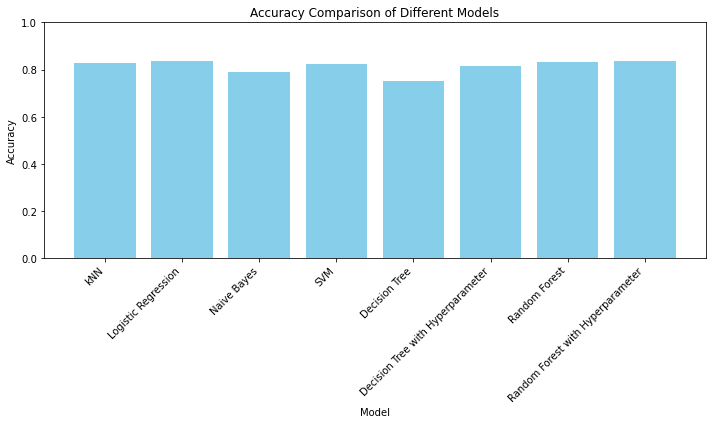

In [42]:
# Accuracy scores for each model
accuracy_scores = {
    'kNN': knn_accuracy,
    'Logistic Regression': accuracy_log_reg,
    'Naive Bayes': accuracy_naive_bayes,
    'SVM': accuracy_svm,
    'Decision Tree': accuracy_decision_tree,
    'Decision Tree with Hyperparameter' : accuracy_decision_tree_hyper_param,
    'Random Forest': accuracy_random_forest,
    'Random Forest with Hyperparameter' : accuracy_random_forest_hyper_param
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1 for accuracy
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
